# Frame Semantic Role Labeller on SweFN

This notebook trains and evaluates a Swedish SRL model based on mT5, with referring to the implementation procedure from the [Frame Semantic Transformer library](https://github.com/chanind/frame-semantic-transformer)

In [1]:
import torch
print(f'built: {torch.backends.cuda.is_built()}')
print(f'CUDNN version: {torch.backends.cudnn.version()}')
torch.cuda.is_available()
# torch.cuda.device_count()

# torch.__version__
# # verify that your graphics card and driver both support the required CUDA version 
# torch.zeros(1).cuda()

# !nvcc --version

built: True
CUDNN version: 8500


True

In [2]:
!nvidia-smi

import os
print(f"num cpus: {os.cpu_count()}")

Wed Jun 14 03:01:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
| 38%   50C    P8    10W / 166W |    874MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Clone the git repo and switch to the multilingual-training-refactor branch
# NOTE: Once this code is merged, you can just do a normal pip install

# !rm -rf /frame-semantic-transformer
# !git clone https://github.com/chanind/frame-semantic-transformer.git
# !git checkout multilingual-training-refactor

In [3]:
import sys
sys.path.append('./frame-semantic-transformer')
%cd ./frame-semantic-transformer

c:\Users\lucyy\Documents\ADS_thesis\toGithub\Model2\frame-semantic-transformer


In [4]:
# check package version
# import transformers
# transformers.__version__

'4.24.0'

In [3]:
# !pip install pytorch_lightning sentencepiece
# Download swedish Framenet XML
# !wget https://svn.spraakdata.gu.se/sb-arkiv/pub/lmf/swefn/swefn.xml

--2023-02-24 11:15:07--  https://svn.spraakdata.gu.se/sb-arkiv/pub/lmf/swefn/swefn.xml
Resolving svn.spraakdata.gu.se (svn.spraakdata.gu.se)... 130.241.135.158
Connecting to svn.spraakdata.gu.se (svn.spraakdata.gu.se)|130.241.135.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7342238 (7,0M) [text/xml]
Saving to: 'swefn.xml'

     0K .......... .......... .......... .......... ..........  0% 1,59M 4s
    50K .......... .......... .......... .......... ..........  1% 3,16M 3s
   100K .......... .......... .......... .......... ..........  2%  109M 2s
   150K .......... .......... .......... .......... ..........  2% 3,27M 2s
   200K .......... .......... .......... .......... ..........  3%  121M 2s
   250K .......... .......... .......... .......... ..........  4%  113M 1s
   300K .......... .......... .......... .......... ..........  4%  118M 1s
   350K .......... .......... .......... .......... ..........  5% 96,1M 1s
   400K .......... .......... ....

In [4]:
# Implement custom Traning and Inference loaders for the Swedish Framenet data
# This is the core step necessary to get FrameSemanticTransformer to work with different languages/framenets

import xml.etree.ElementTree as ET
import random
import re
from typing import List
from frame_semantic_transformer.data.loaders.loader import TrainingLoader, InferenceLoader
from frame_semantic_transformer.data.frame_types import Frame, FrameAnnotatedSentence, FrameAnnotation, FrameElementAnnotation
from frame_semantic_transformer.data.augmentations import (
    DataAugmentation,
    LowercaseAugmentation,
    RemoveEndPunctuationAugmentation,
)
from nltk.stem import SnowballStemmer

swedish_stemmer = SnowballStemmer("swedish")


def extract_frame(xml_frame) -> Frame:
    """
    Extract a Frame element from the Swedish XML for a frame
    """
    name = xml_frame.attrib["id"].replace('swefn--', '')
    core_elms = [
        ft.attrib["val"] for ft in xml_frame.findall(".//feat[@att='coreElement']")
    ]
    non_core_elms = [
        ft.attrib["val"]
        for ft in xml_frame.findall(".//feat[@att='peripheralElement']")
    ]
    lus = [ft.attrib["val"] for ft in xml_frame.findall(".//feat[@att='LU']")]
    # some examples have triggers outside the listed 'LU', but they are usually registerred as 'suggestionForLU'
    lus += [ft.attrib["val"] for ft in xml_frame.findall(".//feat[@att='suggestionForLU']")]

    return Frame(
        name=name,
        core_elements=core_elms,
        non_core_elements=non_core_elms,
        lexical_units=lus,
    )


def extract_example(example_xml, frame_name) -> FrameAnnotatedSentence:
    """
    Extract an annotated training sentence from a Swedish FrameNet Example XML
    NOTE: This isn't ideal since only 1 frame is tagged in each example. This may
    cause the Swedish FrameSemanticTransformer to only ever tag 1 frame per sentence.
    """
    nodes_to_extract = [n for n in example_xml]
    text = ""
    trigger_locs = []
    frame_elements = []
    while len(nodes_to_extract) > 0:
        node = nodes_to_extract.pop(0)
        # sometimes there's nodes in nodes, compound annotation in SweFN
        # in this case, push the children of this node to the front of the queue and keep going
        if len(node) > 0:
            nodes_to_extract = [n for n in node] + nodes_to_extract
        else:
            cur_index = len(text)
            if not node.text:
                continue
            node_text = re.sub(r"\s+", ' ', node.text)
            if node.attrib.get("name") == "LU":
                trigger_locs.append(cur_index)
            elif "name" in node.attrib:
                frame_elements.append(
                    FrameElementAnnotation(
                        name=node.attrib["name"],
                        start_loc=cur_index,
                        end_loc=cur_index + len(node_text),
                    )
                )
            text += node_text + " "
    text = text.strip()
    return FrameAnnotatedSentence(
        text=text,
        annotations=[
            FrameAnnotation(
                frame=frame_name,
                trigger_locs=trigger_locs,
                frame_elements=frame_elements,
            )
        ],
    )


class SwedishTrainingLoader(TrainingLoader):
    """
    Training Loader for Swedish
    This class tells FrameSemanticTransformer how to load the Swedish FrameNet training data
    """
    train_sentences: List[FrameAnnotatedSentence]
    test_sentences: List[FrameAnnotatedSentence]
    val_sentences: List[FrameAnnotatedSentence]


    def __init__(self, swedish_framenet_xml_file, test_portion=0.1, val_portion=0.1, seed=42):
        # parse annotated sentences from XML
        annotated_sentences = []
        tree = ET.parse(swedish_framenet_xml_file)
        root = tree.getroot()
        for xml_frame in root.findall(".//Sense"):
            frame = extract_frame(xml_frame)
            for child in xml_frame:
                if 'example' in child.tag:
                    annotated_sentences.append(extract_example(child, frame.name))
        # split into train/test/val 
        random.Random(seed).shuffle(annotated_sentences)
        num_test = int(test_portion * len(annotated_sentences))
        num_val = int(val_portion * len(annotated_sentences))

        self.test_sentences = annotated_sentences[0:num_test]
        self.val_sentences = annotated_sentences[num_test:num_test + num_val]
        self.train_sentences = annotated_sentences[num_test + num_val:]
    
    def load_training_data(self):
        return self.train_sentences
    
    def load_validation_data(self):
        return self.val_sentences
    
    def load_test_data(self):
        return self.test_sentences
    
    def get_augmentations(self) -> List[DataAugmentation]:
        """
        These augmentations try to increase the training data by making safe tweaks to the text
        For instance, removing the punctuation at the end, or lowercasing the whole sentence
        """
        return [
            RemoveEndPunctuationAugmentation(0.3),
            LowercaseAugmentation(0.2),
        ]


class SwedishInferenceLoader(InferenceLoader):
    """
    Inference loader for Swedish
    This class tells FrameSemanticTransformer which frames and LUs are available during inference
    """

    frames: List[Frame]

    def __init__(self, swedish_framenet_xml_file, test_portion=0.1, val_portion=0.1, seed=42):
        # parse annotated sentences from XML
        self.frames = []
        tree = ET.parse(swedish_framenet_xml_file)
        root = tree.getroot()
        for xml_frame in root.findall(".//Sense"):
            frame = extract_frame(xml_frame)
            self.frames.append(frame)

    def load_frames(self):
        return self.frames
    
    def normalize_lexical_unit_text(self, lu):
        """
        This method normalizes lexical unit text for Swedish during inference
        Lexical Units help give hints to the model about what frames are likely 
        """
        normalized_lu = lu.lower()
        normalized_lu = re.sub(r"\..+$", "", normalized_lu)
        normalized_lu = re.sub(r"[^a-ö ]", " ", normalized_lu)
        
        return "_".join([swedish_stemmer.stem(word) for word in normalized_lu.split()])

In [5]:
%reload_ext tensorboard

In [6]:
%tensorboard --logdir ./lightning_logs --host localhost --port 1009

## Below parts only used for Training

In [7]:
MODEL_TYPE = 'small'

from frame_semantic_transformer.training.train import train
# !rm -rf ./outputs/
# !rm -rf ./lightning_logs/*

In [8]:
# Training quicker
model, tokenizer = train(
    base_model=f"google/mt5-{MODEL_TYPE}",
    # base_model = "./tuned_model1_base",
    batch_size=4,
    max_epochs=30,
    lr=5e-4, ### 5e-4 (epoch 0-15) −→ 1e-4 (epoch 16-20) −→ 5e-5 (epoch 21-30)
    skip_initial_epochs_validation=0,
    num_workers=0, ### due to python multiprocessing NOT working with pytorch
    
    # Here is where we pass in our shiny new Swedish loaders!
    training_loader=SwedishTrainingLoader('./swefn.xml'),
    inference_loader=SwedishInferenceLoader('./swefn.xml'),
)


c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to dis

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [ ]:
# !rm -rf tuned_model_{MODEL_TYPE}
model.save_pretrained(f'tuned_model2_{MODEL_TYPE}')
tokenizer.save_pretrained(f'tuned_model2_{MODEL_TYPE}')

Reduce LR and continue train from the best point of previous run

In [10]:
# Training slower
model, tokenizer = train(
    # base_model=f"google/mt5-{MODEL_TYPE}",
    # base_model = "./tuned_model2_small_mT5",
    base_model = "./outputs_0epo15_lr5e-4/epoch-15-train-loss-0.1284-val-loss-0.3083"
    batch_size=4,
    max_epochs=5,
    lr=1e-4,
    skip_initial_epochs_validation=0,
    num_workers=0, ### due to python multiprocessing NOT working with pytorch
    
    # Here is where we pass in our shiny new Swedish loaders!
    training_loader=SwedishTrainingLoader('./swefn.xml'),
    inference_loader=SwedishInferenceLoader('./swefn.xml'),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | MT5ForConditionalGeneration | 300 M 
------------------------------------------------------
300 M     Trainable params
0         Non-trainable params
300 M     Total params
1,200.707 Total estimated model params size (MB)
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [13]:
# Training slower
model, tokenizer = train(
    # base_model=f"google/mt5-{MODEL_TYPE}",
    # base_model = "./tuned_model2_small_mT5",
    base_model = "./outputs_16epo20_lr1e-4/epoch-4-train-loss-0.0505-val-loss-0.3349",
    batch_size=4,
    max_epochs=10,
    lr=5e-5,
    skip_initial_epochs_validation=0,
    num_workers=0, ### due to python multiprocessing NOT working with pytorch
    
    # Here is where we pass in our shiny new Swedish loaders!
    training_loader=SwedishTrainingLoader('./swefn.xml'),
    inference_loader=SwedishInferenceLoader('./swefn.xml'),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | MT5ForConditionalGeneration | 300 M 
------------------------------------------------------
300 M     Trainable params
0         Non-trainable params
300 M     Total params
1,200.707 Total estimated model params size (MB)
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


#### Manual evaluation on one sentence

In [6]:
def get_TriggerWord (text):
    
    symbol = [" ",",",".","?","!"]
    # monoword trigger
    start_loc = text.find("*")+2
    
    for sym in symbol:
        if text[start_loc:].find(sym)!=-1:
            end_loc = text[start_loc:].find(sym)
            break
        end_loc = len(text[start_loc:])

    trigger = text[start_loc:start_loc+end_loc]

    return trigger

def manual_inference_sentence(chosen_model, text):
    # Let's experiment with the model we just trained
    from frame_semantic_transformer import FrameSemanticTransformer

    # Need to pass in the Swedish inference loader when creating the FrameSemanticTransformer instance, otherwise it will use the Framenet 1.7 loader
    inference_loader = SwedishInferenceLoader('./swefn.xml')
    ##### Adjust this path to use the best-performing model from the "outputs" folder
    transformer = FrameSemanticTransformer(chosen_model, inference_loader=inference_loader)

    result = transformer.detect_frames(text)

    print(f"\n Results found in: {text}")
    print(f"\n Trigger Location: {result.trigger_locations}" )
    locs = result.trigger_locations
    for loc in locs:
        marked_text = result.sentence[:loc] + "* " + result.sentence[loc:]
        print(f"    Trigger word: {get_TriggerWord(marked_text)}")
    
    for frame in result.frames:
        print(f"FRAME: {frame.name}")
        for element in frame.frame_elements:
            print(f"  {element.name}: {element.text}")

In [7]:
# Test the Best model on one sentence
model_path = "./tuned_model2_small_mT5"
manual_text = "Axel fick parkerade på Odengatan , detta gjorde honom pepp ."
manual_inference_sentence(model_path, manual_text)


 Results found in: Axel fick parkerade på Odengatan , detta gjorde honom pepp .

 Trigger Location: [40]
    Trigger word: gjorde
FRAME: Perception_active
  Perceiver_agentive: detta
  Perceiver_agentive: honom pepp


#### F1-score on TEST set

In [8]:
import os
os.getcwd()
# %cd ./frame-semantic-transformer

'c:\\Users\\lucyy\\Documents\\ADS_thesis\\toGithub\\Model2\\frame-semantic-transformer'

In [9]:
# from frame_semantic_transformer.training.evaluate_model import evaluate_model

# "test_model_frame" is created from func "evaluate_model" to speed up
from frame_semantic_transformer.training.test_model_frame import evaluate_model

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from transformers import MT5ForConditionalGeneration, T5TokenizerFast
from frame_semantic_transformer.constants import DEFAULT_NUM_WORKERS, MODEL_MAX_LENGTH

chosen_model_path = "./tuned_model2_small_mT5"
chosen_model = MT5ForConditionalGeneration.from_pretrained(chosen_model_path)
tokenizer = T5TokenizerFast.from_pretrained(chosen_model_path, 
                                            model_max_length=MODEL_MAX_LENGTH)

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

test_results = evaluate_model(
    chosen_model,
    tokenizer,
    loader_cache = lc,
    training_loader =tl,
    batch_size = 4,
    num_workers = 0,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Evaluating on test set


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\miniconda3\envs\dml_nlp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_args_extraction_f1          0.5528689026832581
 test_frame_classification_f1       0.673257052898407
          test_loss                0.36906933784484863
test_trigger_identification_f1      0.5181451439857483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


##### For FrameCL task:   
Get Frame_name (target), input, output in the test set

In [10]:

from frame_semantic_transformer.data.LoaderDataCache import LoaderDataCache
from frame_semantic_transformer.data.tasks_from_annotated_sentences import tasks_from_annotated_sentences

from transformers import MT5ForConditionalGeneration, T5TokenizerFast
from frame_semantic_transformer.constants import MODEL_MAX_LENGTH

from frame_semantic_transformer.predict import batch_predict

import pandas as pd

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_test_data(), lc)     


chosen_model_path = "./tuned_model2_small_mT5"
chosen_model = MT5ForConditionalGeneration.from_pretrained(chosen_model_path)
chosen_tokenizer = T5TokenizerFast.from_pretrained(chosen_model_path, 
                                            model_max_length=MODEL_MAX_LENGTH)

# to store Frame_name of each test sample 
df_test_frameCL = pd.DataFrame(
    [s.get_target(), 
     s.get_input(), 
     batch_predict(chosen_model,  chosen_tokenizer, s.get_input(), num_beams=5, num_return_sequences=1)[0]
     ] for s in samples if s.get_task_name() == "frame_classification" )

df_test_frameCL.columns= ["Frame", "FrameCL_input", "Predict_Frame"]
df_test_frameCL.head()


,Frame,FrameCL_input,Predict_Frame
0,Passing_off,FRAME Feigning Passing_off : En 32-årig man * ...,Passing_off
1,Measure_duration,FRAME Location_in_time Measure_duration Relati...,Temporal_subregion
2,Communication_manner,FRAME Communication_manner Origin : Jag * stam...,Communication_manner
3,Word_relations,FRAME Word_relations : Pojke och tös är * anto...,Word_relations
4,Emotions_of_mental_activity,FRAME Emotions_of_mental_activity Experiencer_...,Emotions_of_mental_activity


In [98]:
os.makedirs('./FrameCL', exist_ok=True)  
df_test_frameCL.to_csv('./FrameCL/test_frameCL_model2_small.csv', index = False)

In [99]:
df_test_frameCL = pd.read_csv('./FrameCL/test_frameCL_model2_small.csv', header = 0)

Group by frame, and sort by F1 score

In [18]:
df_test_frameCL["FrameCL_test_f1"] = df_test_frameCL["Predict_Frame"] == df_test_frameCL["Frame"]

df_frameCL_f1 = df_test_frameCL.loc[:,["Frame","FrameCL_test_f1"]]

grouped_frameCL_f1 = df_frameCL_f1.groupby("Frame", as_index=False).mean()

sort_frameCL_f1 = grouped_frameCL_f1.sort_values("FrameCL_test_f1", ascending=False, inplace= False)
sort_frameCL_f1

,Frame,FrameCL_test_f1
270,Immobilization,1.0
332,Meet_with,1.0
330,Medical_treatment,1.0
325,Means,1.0
322,Manner,1.0
...,...,...
69,Body_mark,0.0
257,Have_visitor_over,0.0
161,Delimitation_of_diversity,0.0
66,Biological_mechanisms,0.0


#### Check # Frames in the train set ===> for Frame CL

In [20]:
from collections import defaultdict

tl = SwedishTrainingLoader('./swefn.xml')
il = SwedishInferenceLoader('./swefn.xml')
lc = LoaderDataCache(il)

samples = tasks_from_annotated_sentences(tl.load_training_data(), lc)

counts_frames_trained: dict[str, int] = defaultdict(int)

for s in samples:
    if s.get_task_name() == 'frame_classification':
        counts_frames_trained[s.get_target()] +=1

print(counts_frames_trained)
print(f'Number trained frames: {len(counts_frames_trained.keys())}')

defaultdict(<class 'int'>, {'Convey_importance': 6, 'Bragging': 13, 'Roadways': 9, 'Placing': 27, 'Arriving': 11, 'Prominence': 10, 'Communication': 13, 'Win_prize': 3, 'Emptying': 56, 'Conditional_occurrence': 3, 'Intentionally_create': 12, 'Within_distance': 2, 'Cause_to_be_wet': 11, 'Gesture': 9, 'Foreign_influence': 16, 'Set_of_interrelated_entities': 4, 'Grammatical_relations': 10, 'Part_inner_outer': 27, 'Discussion': 4, 'Suitability': 2, 'Self_motion': 45, 'Expected_location_of_person': 5, 'Suasion': 6, 'Closure': 26, 'Rate_quantification': 2, 'Part_ordered_segments': 25, 'Ranked_expectation': 17, 'Reveal_secret': 17, 'Cause_to_be_dry': 13, 'Communication_manner': 16, 'Law_enforcement_agency': 4, 'Subjective_influence': 8, 'Drop_in_on': 6, 'Clarity_of_resolution': 5, 'Manipulation': 11, 'Agriculture': 6, 'Administration_of_medication_specification': 12, 'Telling': 11, 'Make_noise': 51, 'Renting': 4, 'Precipitation': 10, 'Being_named': 9, 'Gusto': 6, 'Omen': 26, 'Judgement_of_int

In [21]:
# Sort Frame by # of examples
counts_frames_trained_sort = sorted(counts_frames_trained.items(), key = lambda item: item[1])
counts_frames_trained_sort [-10:]

[('Create_representation', 33),
 ('Removing', 34),
 ('Experiencer_obj', 34),
 ('Ingestion', 38),
 ('Cutting', 39),
 ('Medical_treatment', 42),
 ('Self_motion', 45),
 ('Grooming', 46),
 ('Make_noise', 51),
 ('Emptying', 56)]

In [22]:
sum(counts_frames_trained.values())

7648

Create Graphs ---- FrameCL

NOTE: 1039 seen frames during the training, but 541 are tested

In [23]:
# Scater: # train_samples v.s. test_F1 per frame
sort_frameCL_f1["num_train_samples"] = sort_frameCL_f1["Frame"].map(counts_frames_trained)
sort_frameCL_f1

,Frame,FrameCL_test_f1,num_train_samples
270,Immobilization,1.0,5
332,Meet_with,1.0,3
330,Medical_treatment,1.0,42
325,Means,1.0,8
322,Manner,1.0,5
...,...,...,...
69,Body_mark,0.0,9
257,Have_visitor_over,0.0,3
161,Delimitation_of_diversity,0.0,2
66,Biological_mechanisms,0.0,8


<AxesSubplot: xlabel='num_train_samples', ylabel='FrameCL_test_f1'>

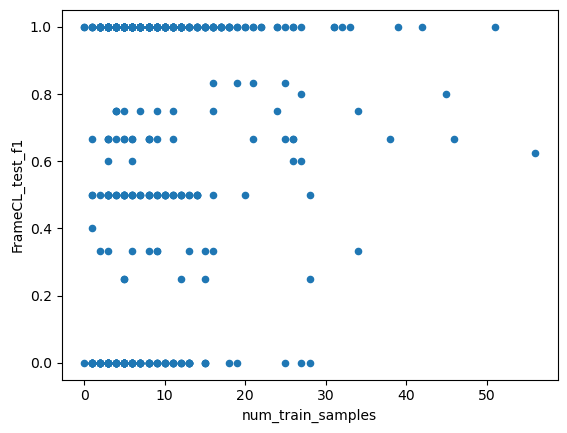

In [24]:
sort_frameCL_f1.plot.scatter("num_train_samples", "FrameCL_test_f1")

#### EASY frames
The frames that suits best for the training are the frames: 

In [55]:
# frames < 3 samples but f1 = 1

easy_frame = sort_frameCL_f1[(sort_frameCL_f1["num_train_samples"]<3) & (sort_frameCL_f1["FrameCL_test_f1"]==1)]
easy_frame_model2_small = easy_frame.iloc[:,[0]]
easy_frame_model2_small

,Frame
320,Manipulate_into_shape
307,Limitation
294,Judicial_body
348,Non-commutative_process
258,Health_response
247,Gizmo
496,Surrendering_possession
495,Surrendering
487,Subjective_temperature
528,Used_up


In [172]:
len(easy_frame_model2_small)

20

In [56]:
os.makedirs('./FrameCL', exist_ok=True)  
easy_frame_model2_small.to_csv('./FrameCL/easy_frame_model2_small.csv', index = False)

In [57]:
easy_frame_model2_small = pd.read_csv('./FrameCL/easy_frame_model2_small.csv')

In [64]:
easy_frame_model2_small.sort_values('Frame', inplace = True)
easy_frame_model2_small

,Frame
19,Being_questionable
17,Cause_emotion
16,Cause_to_be_sharp
15,Change_event_duration
14,Conferring_benefit
18,Dynamism
13,Event_instance
5,Gizmo
4,Health_response
2,Judicial_body


In [87]:
# get easy_frame from Model1-small
easyFrame_model1_small = ["Limitation",
"Judicial_body",
"Losing_it",
"Dynamism",
"Event_instance",
"Gizmo",
"Subjective_temperature",
"Serving_in_capacity",
"Surrendering",
"Surrendering_possession",
"Typicality",
"Process_resume",
"Robbery",
"Commutative_process",
"Conferring_benefit",
"Cause_emotion",
"Being_questionable"
]

df_easyFrame_model1_small = pd.DataFrame(easyFrame_model1_small, columns = ['Frame'])
df_easyFrame_model1_small.to_csv('./FrameCL/easy_frame_model1_small.csv', index = False)

In [88]:
df_easyFrame_model1_small =  pd.read_csv('./FrameCL/easy_frame_model1_small.csv')

In [89]:
df_easyFrame_model1_small.sort_values('Frame', inplace = True)
df_easyFrame_model1_small

,Frame
16,Being_questionable
15,Cause_emotion
13,Commutative_process
14,Conferring_benefit
3,Dynamism
4,Event_instance
5,Gizmo
1,Judicial_body
0,Limitation
2,Losing_it


In [93]:
# common easy Frames
A = set(list(easy_frame_model2_small['Frame']))
B = set(list(df_easyFrame_model1_small['Frame']))

In [96]:
# common EASY frames
A & B

{'Being_questionable',
 'Cause_emotion',
 'Conferring_benefit',
 'Dynamism',
 'Event_instance',
 'Gizmo',
 'Judicial_body',
 'Limitation',
 'Process_resume',
 'Subjective_temperature',
 'Surrendering',
 'Surrendering_possession',
 'Typicality'}

In [182]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Commutative_process"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
699,Commutative_process,FRAME Commutative_process : Hos zinketyl med k...,Commutative_process,True
909,Commutative_process,FRAME Commutative_process : Jag var just inne ...,Eventive_process,False


Comments:

+ <'Limitation'> has 1 LU: begränsning ==> only listed under this 1 frame
+ <'Judicial_body'> has only 2 sentences with "unique" triggers: domstol & rättslig that only listed under this frame
+ <'Being_questionable', 'Cause_emotion', 'Conferring_benefit', 'Dynamism', 'Gizmo', 'Typicality'> ==> only listed under this 1 frame


+ <'Event_instance'> all example triggers are "gång" or its bigrams; "gång" has only been trained under this frame even though it is listed under multiple frames
+ <'Surrendering_possession'>: avträda has only been trained under this frame 


+ <'Subjective_temperature'>: trigger "iskall" has only been trained under this frame
+ <'Surrendering'>: överlämna_sig has only been trained under this frame 

In [92]:
# easy for Model 2, but not failed by Model 1
A - B

{'Cause_to_be_sharp',
 'Change_event_duration',
 'Health_response',
 'Manipulate_into_shape',
 'Non-commutative_process',
 'Prison',
 'Used_up'}

+ only frame in the hint: Cause_to_be_sharp, Health_response, Manipulate_into_shape

+ only been trained in this frame: Change_event_duration ('förkorta'), Non-commutative_process

+ <'Prison' ('fängelse'), 'Used_up' ('uttömma')>: no matched frames in the hint; fängelse only been trained in this frame

t.ex.
Completeness,"FRAME Completeness Used_up : Man skulle behöva * uttömmande bakgrundsinformation, riskanalyser, parallella studier med och utan syresättning, och uppföljning."

In [91]:
# correct by Model 1, but failed by Model 2
B - A

{'Commutative_process', 'Losing_it', 'Robbery', 'Serving_in_capacity'}

<'Commutative_process'>: mT5 model seems utilized its pre-established connections among Swedish and English words to "create" a new Frame Name "Eventive_process"; 
Commutative_process,FRAME Commutative_process : Jag var just inne på posten och * gångrade och delade i huvet.,Eventive_process,False

<'Losing_it'>: the trigger "explodera" has not yet been seen
Losing_it,FRAME Breaking_apart Losing_it : Igår höll jag på att * explodera.,Breaking_apart,False

<'Robbery'> the trigger has not been trained with the target frame, and there seems to have dependency between Rape and Råna
Robbery,FRAME Food Robbery : Två yngre killar * rånar två tjejer på deras väskor på Odinsgatan.,Rape,False

<'Serving_in_capacity'>: for the trigger "tjäna som", are both the true and predicted frames are common.
Serving_in_capacity,"FRAME Assistance Attention_getting Earnings_and_losses Function People_by_vocation Serving_in_capacity : Redan en sexårig flicka kunde * tjäna som lillpiga, säger Rehn.",Function,False

CONCLUSIOIN:
when the trigger has not been seen or trained with the target Frame, T5 seems more reply on the fine-trained relation, but mT5 seems to be able to predict with its pre-established depency between English-Swedish words, sometimes even a NEW Created frame

#### HARD frames
The frames that suits worst for the training are the frames: 

In [30]:
# frames >20 samples but f1 < 0.6

hard_frame = sort_frameCL_f1[(sort_frameCL_f1["num_train_samples"]>20) & (sort_frameCL_f1["FrameCL_test_f1"]<0.6)]["Frame"]
hard_frame

471               Simultaneity
431                   Removing
227                    Filling
92                Cause_motion
359      Part_ordered_segments
400    Proliferating_in_number
Name: Frame, dtype: object

In [86]:
# get easy_frame from Model1-small
hard_Frame_model1_small = ["Part_ordered_segments",
"Part_inner_outer",
"Make_noise",
"Firing",
"Relational_political_locales",
"Predicting",
"Closure",
"Path_traveled",
"Proliferating_in_number",
"Removing",
"Simultaneity",
"Filling",
"Grooming",
"Point_of_dispute",
"Cause_motion"
]

hard_Frame_model1_small = pd.DataFrame(hard_Frame_model1_small, columns = ['Frame'])
hard_Frame_model1_small.to_csv('./FrameCL/hard_frame_model1_small.csv', index = False)

In [151]:
C = set(list(hard_frame))
D = set(list(hard_Frame_model1_small['Frame']))

In [152]:
# the common Hard frames
C & D

{'Cause_motion',
 'Filling',
 'Part_ordered_segments',
 'Proliferating_in_number',
 'Removing',
 'Simultaneity'}

In [168]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Cause_motion"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
245,Cause_motion,"FRAME : Den * bortvältrade stenen, den tomma ...",Detaching,False


reason 1: trigger is a compound word but the listed LU is of multiple words ==> no matched LUs in the hints + less common word (never seen in train set)

e.g. vältra_bort v.s. bortvältrade

In [169]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Part_ordered_segments"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
122,Part_ordered_segments,FRAME : Det är svenskt i topp i första *åket ...,Finish_competition,False
227,Part_ordered_segments,FRAME Cause_harm Part_ordered_segments : Sex o...,Cause_harm,False


In [170]:
text1 = "åk..2"
text2 = "åket"

print(f'{text1}: {normalize_text(text1)}')
print(f'{text2} : {normalize_text(text2)}')

åk..2: åk
åket : åket


- Part_ordered_segments,FRAME  : Det är svenskt i topp i första *åket i damernas världscupslalom i Åre.,Finish_competition,False

- Part_ordered_segments,FRAME Cause_harm Part_ordered_segments : Sex ordinarie spelare från förra säsongen är borta då handbollsdamerna i Åbo IFK på lördag reser till Helsingfors för ett möte med Sparta i första * omgången av FM-serien.,Cause_harm,False

reason 2: trigger "åket" is not the same as the listed LUs after lemmatization + few train sample

In [167]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Filling"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
165,Filling,FRAME Administration_of_medication_conveyance ...,Erasing,False
202,Filling,FRAME Cause_to_fragment Event Filling Beat_opp...,Filling,True
379,Filling,FRAME Corporal_punishment Filling Rite Substan...,Rite,False
380,Filling,"FRAME : Jag smörjer dem, och * beströr dem of...",Emptying,False


- Filling,FRAME Administration_of_medication_conveyance Corporal_punishment Erasing Filling Reshaping Self_motion : För att det ska bli lättare att * stryka färgen tunt brukar man använda lösningsmedel i grundstrykningen.,Erasing,False
- Filling,"FRAME Corporal_punishment Filling Rite Substance : Jag * smörjer dem, och beströr dem ofta med mjöl, innan jag trycker ner degen.",Rite,False
- Filling,"FRAME  : Jag smörjer dem, och * beströr dem ofta med mjöl, innan jag trycker ner degen.",Emptying,False

reason 3: too many matched LUs in the hint, and the targeted Frame contains few no samples of the trigger "stryka" "beströr", + other Frames have been trained with this trigger "smörja" by similar-structured senteces


In [154]:
# the hard frames for Model1 but improved by Model 2
D - C

{'Closure',
 'Firing',
 'Grooming',
 'Make_noise',
 'Part_inner_outer',
 'Path_traveled',
 'Point_of_dispute',
 'Predicting',
 'Relational_political_locales'}

What have been improved by Model 2?


In [155]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Closure"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
382,Closure,FRAME : För att övervaka * slutna områden ino...,Closure,True
474,Closure,FRAME Closure : Nu har syrran * sabrerat en Ta...,Closure,True


In [157]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Grooming"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
67,Grooming,FRAME Family_name Hair_configuration Reshaping...,Hair_configuration,False
191,Grooming,FRAME Grooming Building_subparts Scouring : Ha...,Grooming,True
331,Grooming,FRAME : Har lagt alla kläder i tvättkorgen oc...,Grooming,True


In [162]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Point_of_dispute"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
121,Point_of_dispute,FRAME : Jag vet inte om Zizek menar att * pro...,Point_of_dispute,True


In [160]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Part_inner_outer"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
284,Part_inner_outer,FRAME Part_inner_outer Temporal_subregion : Ti...,Part_inner_outer,True
932,Part_inner_outer,FRAME Emptying Part_inner_outer : Av sköldpadd...,Part_inner_outer,True


Make_noise,FRAME Besieging Communication Communication_means Locative_relation Make_noise Accoutrements Cause_to_make_noise Locale_by_use Shapes : Det märks kanske tydligast när klockan * ringer in samtliga till votering.,Make_noise,True

Make_noise,FRAME Besieging Communication Communication_means Locative_relation Make_noise Accoutrements Cause_to_make_noise Locale_by_use Shapes : De rusar in till lektionen när det * ringer in.,Make_noise,True

In [163]:
df_test_frameCL.loc[df_test_frameCL["Frame"] == "Predicting"]

,Frame,FrameCL_input,Predict_Frame,FrameCL_test_f1
72,Predicting,FRAME : Galluparna * förutspår valframgång fö...,Predicting,True
276,Predicting,FRAME : Roselius tillägger att det funnits de...,Breaking_apart,False
304,Predicting,FRAME Predicting : Nybond vågar inte * sia om ...,Predicting,True
358,Predicting,FRAME : VD Mats Jansson * spådde vid stämman ...,Predicting,True
534,Predicting,"FRAME Predicting : Ingar Storm, denna fantasti...",Predicting,True
809,Predicting,FRAME : Moderator under kvällen som arrangöre...,Predicting,True


Predicting,FRAME  : Galluparna * förutspår valframgång för Sannfinländarna.,Predicting,True
Predicting,FRAME  : VD Mats Jansson * spådde vid stämman en fortsatt positiv utveckling för bolaget.,Predicting,True
Predicting,"FRAME  : Moderator under kvällen som arrangörerna * förutspår att {moderator} kan bli både tung och givande, är journalisten Sebastian Bergholm.",Predicting,True


Predicting,FRAME  : Roselius tillägger att det funnits de som * spått rörelsens död varje år.,Breaking_apart,False

Comments:
mT5 not only reply on the hints, which gives the advantage to predict the correct Frame when hint-list is empty due to either missing in listed LUs or failing in lemmatization
Indeed, the Swedish SnowballStemmer does not always lemmatize well, would be better to apply several stemmers like the English SRL model.
either missing the trigger in listed LUs due to 